# Audio Decomposition

In this homework we will explore NMF-based audio decomposition.

We are getting close to the final project, so I will be providing very little hand holding in this assignment.  I will simply give you broad tasks to accomplish without providing decomposed functions or answers.  It is up to you to verify that your code is working!

Please note that part of your grade will be on the readability and decomposition of your code, so make sure your code is clean and organized.  Part of your grade will also be on the clarity of your writing.  You should explain your thought process clearly and support your claims with appropriate plots.

Team member #1: __________

Hours spent on hw: ____________

Team member #2: ___________

Hours spent on hw: ____________

In [4]:
%matplotlib inline

In [93]:
import numpy as np
import librosa as lb
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy.io as si
from scipy.signal import stft, istft
import math

### NMF (30 points)

In this section you will implement the NMF algorithm.  You should do the following:
- Calculate the STFT of the given audio file ('xylophone.mp3').
- Implement the NMF algorithm as described in class.
- Describe a suitable stopping criterion and justify your selection with logic and/or experimental plots.
- Run NMF on the magnitude STFT
- Visualize the estimated template and activation matrices.  Comment on the results.

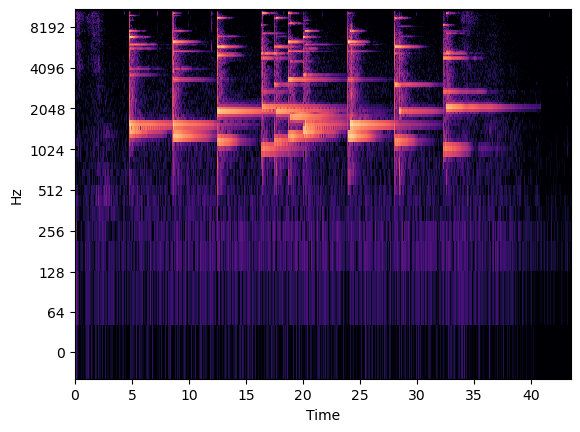

In [14]:
x, Fs = lb.load('xylophone.mp3', sr=22050)
f, t, stft_x = stft(x)
D = np.abs(stft_x)
db = lb.amplitude_to_db(D, ref=np.max)
lb.display.specshow(db, sr= Fs, y_axis='log', x_axis='time')

In [19]:
K, N = stft_x.shape
R = 8
# Initializing W
W = np.zeros((K, R))

In [110]:
def NMFAlg(V, stop=2):
    K, N = V.shape
    W, H = initializeWH(K, N)
    
    epsilon = 1e-9
    
    for i in range(stop):
        H = H * (W.T @ V) / ((W.T @ W @ H ) + epsilon)
        W = W * (V @ H.T) / ((W @ H @ H.T) + epsilon)
    
    return W, H

In [58]:
def initializeWH(K, N, f_marg=1.03):
    notes = [1046.50, 1174.66, 1318.51, 1396.91, 1567.98, 1760.00, 1975.53, 2093.00] # Hz
    noteNames = ['C6', 'D6', 'E6', 'F6', 'G6', 'A6', 'B6', 'C7']
    
    
    # Initializing W, H
    W = np.zeros((K, len(notes)))
    H = np.ones((len(notes), N))
    
    # Fundamental
    spacing = 22050 / 256 # fs / hop
    
    rowInds = np.arange(K)
    
    # Initializing W
    for c in range(len(notes)):
        noteFreq = notes[c]
        m_low = (noteFreq / spacing) / f_marg
        m_high = (noteFreq / spacing) * f_marg
        #print(m_low, m_high, noteFreq/spacing)
        
        goodRowInds = (rowInds >= m_low) * (rowInds <= m_high)
        W[goodRowInds, c] = 1
    
    return W, H

In [111]:
W, H = NMFAlg(np.abs(stft_x))

In [89]:
W

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [90]:
H

array([[4.35227284e-10, 0.00000000e+00, 2.57634335e-08, ...,
        2.58056091e-05, 1.61179768e-05, 1.55862692e-05],
       [5.75987823e-10, 0.00000000e+00, 4.69761893e-08, ...,
        1.72441543e-05, 1.23897536e-05, 8.03913168e-06],
       [6.56154790e-10, 0.00000000e+00, 6.93143372e-08, ...,
        1.11241554e-05, 2.20806605e-05, 5.83704574e-06],
       ...,
       [1.76416694e-09, 0.00000000e+00, 1.85754250e-08, ...,
        9.71379063e-06, 1.95601672e-05, 7.52603410e-06],
       [1.57129674e-09, 0.00000000e+00, 6.47269775e-09, ...,
        7.76652264e-06, 6.78583910e-06, 8.58669337e-06],
       [2.19027062e-09, 0.00000000e+00, 3.22764461e-09, ...,
        3.69121551e-06, 4.49963011e-06, 6.01986038e-06]])

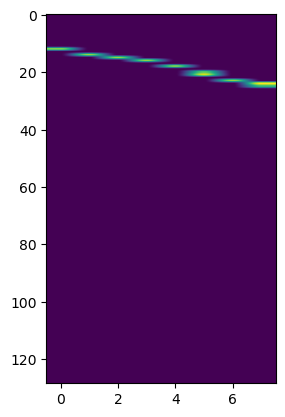

In [91]:
ax = plt.axes()
ax.imshow(W)
ax.set_aspect(0.1)

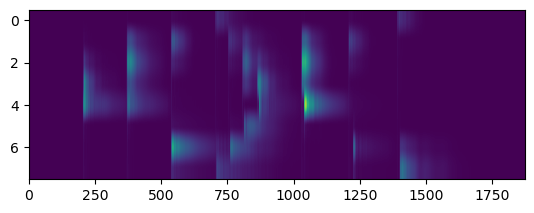

In [92]:
ax = plt.axes()
ax.imshow(H)
ax.set_aspect(80)

## - Describe a suitable stopping criterion and justify your selection with logic and/or experimental plots.

 1. Pick a number
2. Compare V to reconstructed result WH
3. For each iteration compare how much has changed since the previous until a 'steady-state' is reached

### Reconstruction (15 points)

In this section you will reconstruct the audio for the estimated left and right hand tracks.  You should do the following:
- Implement the simple approach described in class
- Implement the soft masking approach described in class
- Listen to the results of both reconstruction methods.  Comment.

In [106]:
def reconstruct(W, H, V, fs=22050):
    R, N = H.shape
    
    leftMask = np.arange(R).reshape([R, 1]) < 4
    rightMask = np.arange(R).reshape([R, 1]) >= 4
    
    H_left = leftMask * H
    H_right = rightMask * H
    
    wh_l = W @ H_left
    wh_r = W @ H_right
    
    Vphases = np.exp(1j*np.angle(V))
    
    wh_lphase = Vphases * wh_l
    wh_rphase = Vphases * wh_r
    
    t_r, invSTFT_r = istft(wh_rphase, fs)
    t_l, invSTFT_l = istft(wh_lphase, fs)
    
    return invSTFT_l, invSTFT_r

In [107]:
reconstruct(W, H, stft_x)

(array([-1.08519989e-09, -1.78144693e-09, -2.25149151e-09, ...,
         2.87058438e-05,  2.22559208e-05,  1.35945016e-05]),
 array([-3.71805134e-09, -8.26686062e-09, -1.03742312e-08, ...,
         1.44155293e-05,  9.01372066e-06,  1.19215427e-06]))

In [112]:
left, right = reconstruct(W, H, stft_x)
ipd.Audio(left, rate=22050)

In [109]:
ipd.Audio(right, rate=22050)

### Initializing templates (15 points)

In this section you will initialize the templates to incorporate prior knowledge.  You should do the following:
- Create a function that initializes a template matrix given a set of midi note numbers.  The templates should have random positive values around harmonic frequencies (+/- half a semitone), and zeros elsewhere.
- Visualize the initialized template matrix using the notes {C6, D6, E6, F6, G6, A6, B6, C7}.
- Run NMF with the initialized template matrix
- Visualize the resulting template and activation matrices.  Comment.
- Sonify the left and right hand tracks.  Comment.

In [ ]:
# Check Part A

### Initializing Activations (10 points)

In this section you will initialize the activations to incorporate prior knowledge.  You may assume that you have already aligned the score and the audio, and have predicted the following note events at the following times.  You should do the following:
- Create a function that initializes an activation matrix given the note event information.  The entries should have random positive values around the note onsets, and zeros elsewhere.  You may assume a fixed note duration of 1 sec.
- Visualize the initialized activation matrix
- Run NMF with the initialized template and activation matrices
- Visualize the resulting template and activation matrices. Comment.
- Sonify the left and right hand tracks. Comment.

In [32]:
noteEvents = [(3, 1.23), (4, 1.23), (2, 2.19), (4, 2.19), (1, 3.16), (6, 3.16), 
              (0, 4.12), (7, 4.12), (1, 4.42), (6, 4.42), (2, 4.72), (5, 4.72),
              (3, 5.05), (4, 5.05), (2, 6.02), (4, 6.02), (1, 7.05), (6, 7.05),
              (0, 8.11), (7, 8.11)]

### Onset Models (10 points)

In this section you will add onset models to your system.  You should do the following:
- Create a function that initializes a note & onset template matrix given a set of midi note numbers.  The note templates should have random positive values around harmonic frequencies, and zeros elsewhere.  The onset templates should have all random positive values.
- Create a function that initializes a note & onset activation matrix given the note event information.  The note activations should have random positive values for the interval (t_onset, t_onset+1.0), and zeros elsewhere.  The onset activations should have random positive values for the interval (t_onset - margin, t_onset + margin), and zeros elsewhere.
- Visualize the initialized template & activation matrices.
- Run NMF with the initialized template and activation matrices.
- Visualize the resulting template and activation matrices. Comment.
- Sonify the left and right hand tracks. Comment.